# The Pedal Board Finder
## A Google Shopping scraper that utilizes fundamental NLP techniques to analyze review data for different products given a search query.
### My goal is to find the best reviewed guitar effect pedals. First, I'll perform sentiment analysis on review data, then I'll topic model the positive and negative class to see what good/bad things people are saying about the product.

# 1 - Data Gathering/Processing/EDA
---
## 1.1 - Review Data Gathering. 

In [1]:
from pyfuncs import scraper
from time import sleep
import pandas as pd

In [2]:
search_terms = ['fuzz pedal', 'delay pedal', 'wah pedal', 'octave pedal']


In [3]:
#These are the pedal's I'm interested in. I ran this scraper already. The google shopping scraper can be found in 
#notebooks/pyfuncs/scraper

def get_review_data():
    '''Uses the google shopping scraper class found in pyfuncs/scraper to fetch reviews 
    for each product given a search query.
    
    ::params:: search_terms: list of strings of terms you're interested in scraping.
    
    ::returns:: None, saves pickled dataframe objects for each search term in working directory.
    '''
    for term in search_terms:
        try:
            Shopper = scraper.Google_Shopping_Scraper(term, n_reviews=200, n_pages=10)
            sleep(10)
        except:
            print('retrying search')
            sleep(1)
            Shopper.driver.close()
            sleep(1)
            Shopper = scraper.Google_Shopping_Scraper(term, n_reviews=200, n_pages=10)
        Shopper.get_all_pages()
        corpus_df = pd.DataFrame(Shopper.all_reviews)
        term = term.replace(' ','_')
        corpus_df.to_pickle(f'{term}.pkl')
        Shopper.driver.close()
    pass

## 1.2 - Text Cleaning.

In [4]:
from pyfuncs import text_funcs

In [5]:
for term in search_terms:
    raw_df = pd.read_pickle(f'{term.replace(" ", "_")}.pkl')
    clean_reviews = text_funcs.cleaner(raw_df['review'], remove_non_english = False)
    raw_df['review'] = clean_reviews
    raw_df.to_pickle(f'{term.replace(" ", "_")}_cleaned.pkl')

## 1.3 - EDA.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corpus = dict()
for term in search_terms:
    print(term)
    corpus[f"{term.replace(' ', '_').replace('_cleaned', '')}"] = \
        pd.read_pickle(f"{term.replace(' ', '_')}_cleaned.pkl")

fuzz pedal
delay pedal
wah pedal
octave pedal


In [7]:
def get_class_counts(corpus_dict, rating_col):
    '''Returns class counts to check for class imbalance'''
    fig, axs = plt.subplots(2, 2, figsize=(20,20))
    for i, df_key in enumerate(corpus_dict.keys()):
        counts = corpus[df_key][rating_col].value_counts()
        sns.barplot(counts.index, counts.values, ax=axs.flat[i])
        axs.flat[i].set_title(str(df_key).replace("_", " "), size=30)
        axs.flat[i].tick_params(axis='both', which='major', labelsize=25)
    pass

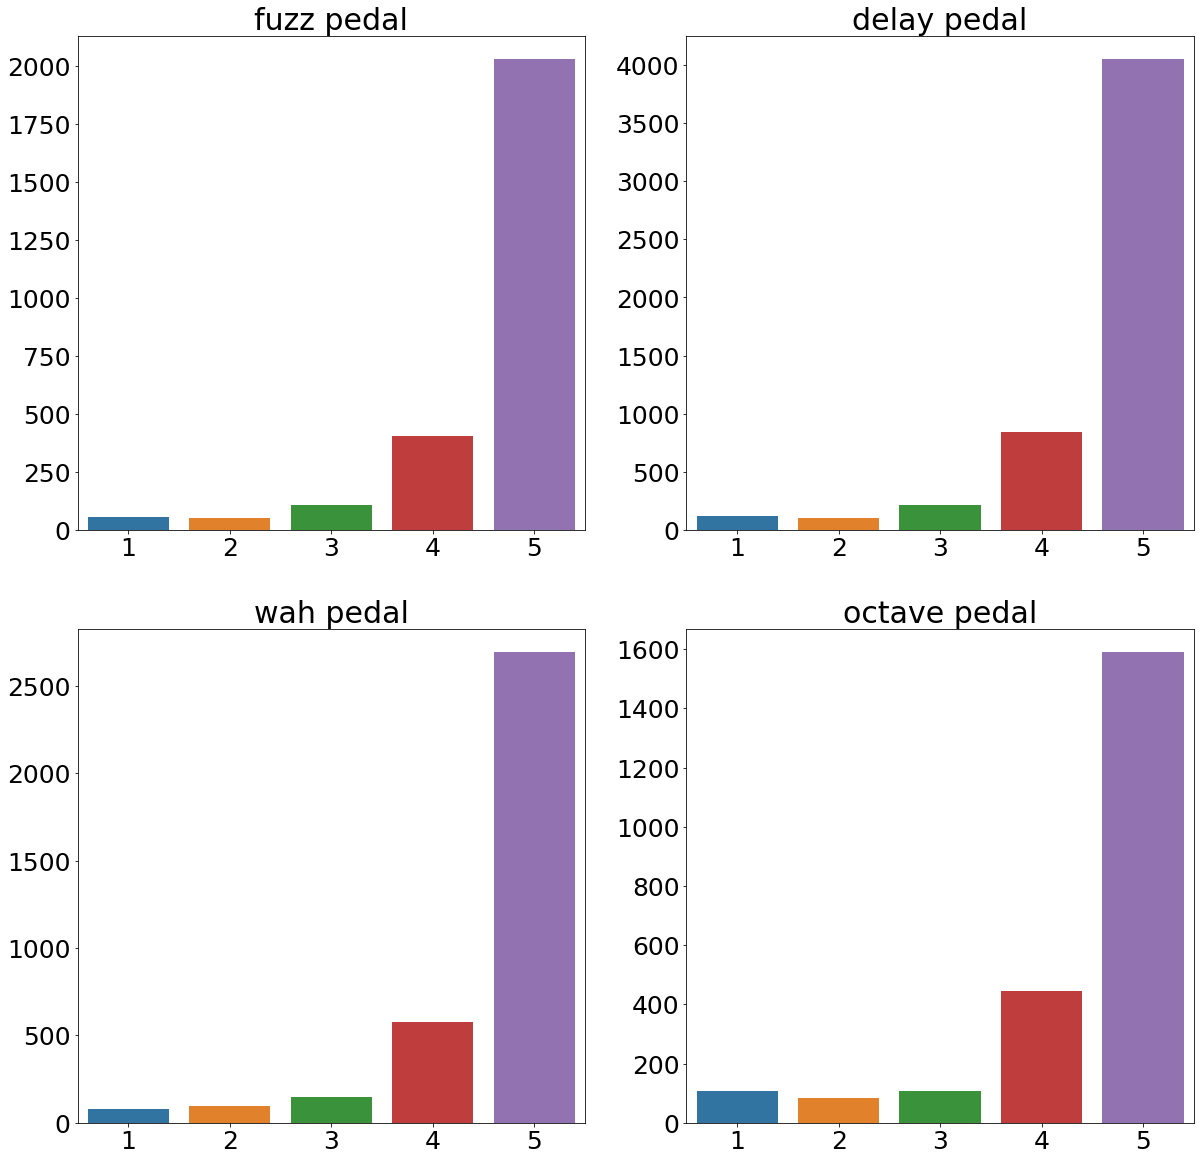

In [8]:
get_class_counts(corpus, 'review_ratings')

### There does seem to be a fairly large class imbalance, Will try to group ratings 1,2 -> negative, 3-> neutral, 4,5-> positive.

In [9]:
for df_key in corpus.keys():
    corpus[df_key]['2_group_rating'] = text_funcs.get_pos_neg_neut(corpus[df_key]['review_ratings'], neutral_class=False)
    corpus[df_key]['3_group_rating'] = text_funcs.get_pos_neg_neut(corpus[df_key]['review_ratings'])

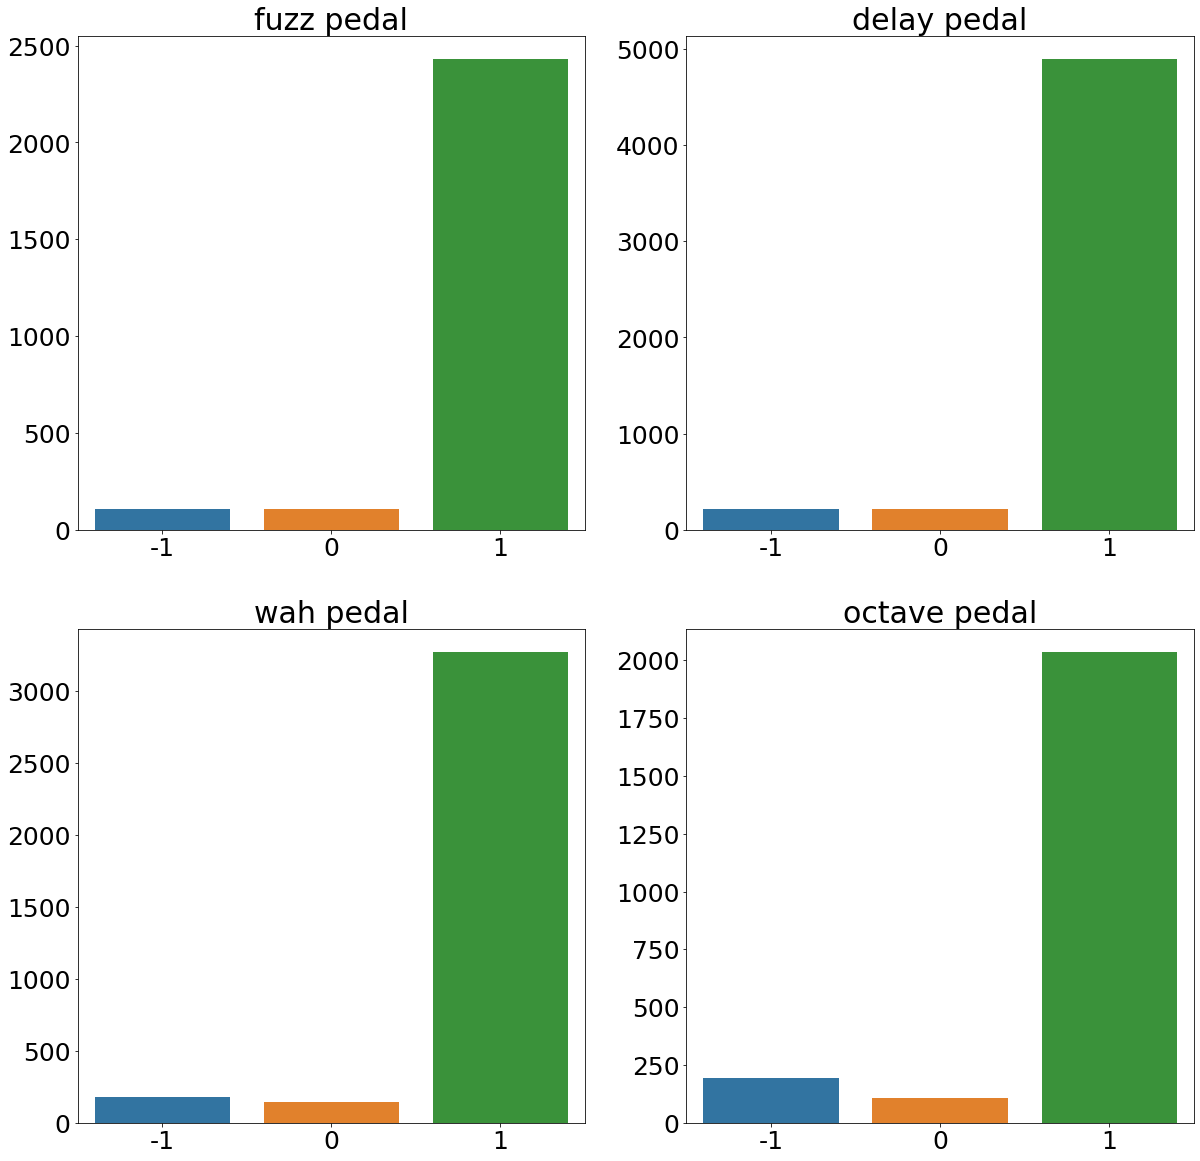

In [10]:
get_class_counts(corpus, '3_group_rating')

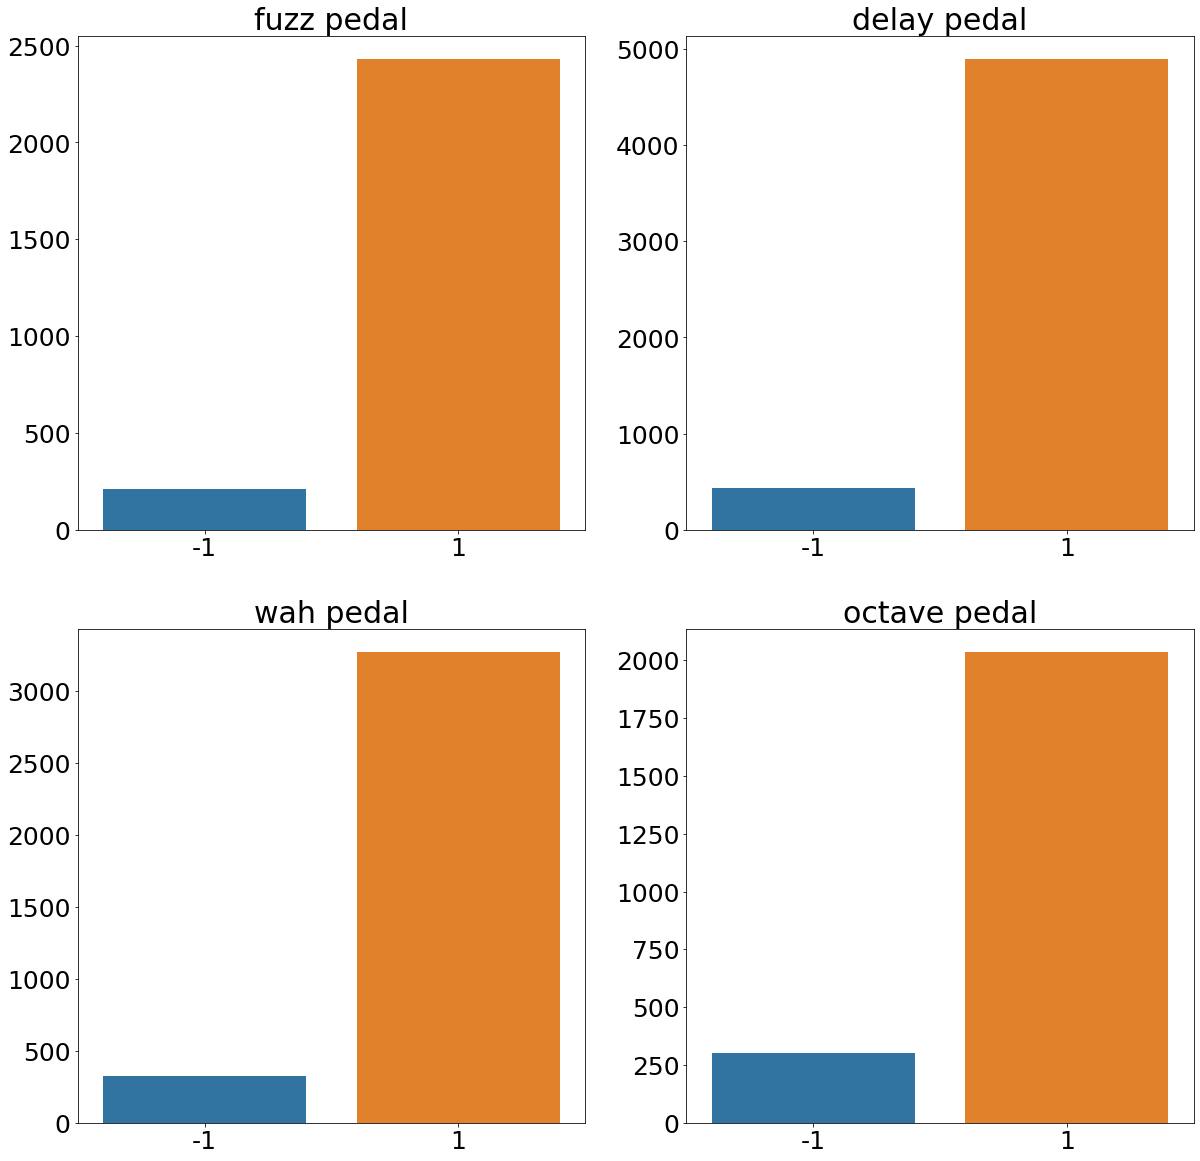

In [11]:
get_class_counts(corpus, '2_group_rating')

## 1.4 - Train/Test Split 

In [12]:
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [13]:
octave = corpus['octave_pedal']
fuzz = corpus['fuzz_pedal']
delay = corpus['delay_pedal']
wah = corpus['wah_pedal']
dfs = [octave, fuzz, delay, wah]

def train_test(dfs):
    '''splits each product review df into train/test sets. 
    returns train_corpus/test_corpus dictionaries'''
    test_corpus = defaultdict(list)
    train_corpus = defaultdict(list)
    for df in dfs:
        X, y = df['review'], df['2_group_rating']
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        train_corpus['pedal'].append(df['search'][0])
        test_corpus['pedal'].append(df['search'][0])
        train_corpus['y'].append(y_train)
        test_corpus['y'].append(y_test)
        train_corpus['X'].append(X_train)
        test_corpus['X'].append(X_test)
    return train_corpus, test_corpus

In [14]:
Train, Test = train_test(dfs)

In [15]:
Test['X']

[1370    tracks really well this is a very nice pedal i...
 1645    boss you are godly when i started playing guit...
 1968    review of boss  super octave compact pedal gre...
 295     excellently built pedal feels a lot more robus...
 28      not what i expected i saw a review and it soun...
                               ...                        
 848     i does what it says it does this really works ...
 1086    fantastic  rate glass just awesome picture qua...
 2103                                      cheap but good 
 1686    incredible sounds and tracking i installed a r...
 2308    its a pedal and it operates and sounds like a ...
 Name: review, Length: 584, dtype: object,
 44      good raunchy sounding dirt box recently picked...
 2560    sweet sweepable mids in real time adjustable a...
 1734    review of electro harmonix deluxe bass big muf...
 252     its a nice little fuzz pedal and for the price...
 1684    amazing fuzz easy to use sounds amazing anythi...
             

# 2 - Sentiment Analysis
---
## 2.1 Supervised Sentiment Analysis with Rule Based Tools.
### 2.1.1 Vader Sentiment.

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [17]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [18]:
def get_vader_scores(Train):
    scores = defaultdict(list)
    for ix in range(4):
        for review in Train['X'][ix]:
            scores[ix].append(sentiment_analyzer_scores(review))
    return scores

In [19]:
scores = get_vader_scores(Train)

In [20]:
def predict_vader_sentiment(scores):
    '''Predicts all scores for each of the 4 products'''
    predictions = defaultdict(list)
    for ix in range(4):
        for review_score in scores[ix]:
            if review_score['neg'] >= review_score['pos']:
                predictions[ix].append(-1)
            else:
                predictions[ix].append(1)
    return predictions

In [21]:
ypred = predict_vader_sentiment(scores)

In [22]:
from sklearn.metrics import classification_report

def get_all_reports(ypred, Train):
    for ix in range(4):
        print(Train['pedal'][ix])
        print(classification_report(Train['y'][ix], ypred[ix]))
        print('\n')
    pass

get_all_reports(ypred, Train)

octave pedal
              precision    recall  f1-score   support

          -1       0.49      0.45      0.47       222
           1       0.92      0.93      0.93      1530

    accuracy                           0.87      1752
   macro avg       0.71      0.69      0.70      1752
weighted avg       0.87      0.87      0.87      1752



fuzz pedal
              precision    recall  f1-score   support

          -1       0.26      0.36      0.30       152
           1       0.94      0.91      0.93      1828

    accuracy                           0.87      1980
   macro avg       0.60      0.63      0.61      1980
weighted avg       0.89      0.87      0.88      1980



delay pedal
              precision    recall  f1-score   support

          -1       0.28      0.45      0.35       321
           1       0.95      0.90      0.92      3676

    accuracy                           0.86      3997
   macro avg       0.62      0.68      0.64      3997
weighted avg       0.90      0.86 

#### It seems like vader sentiment has a hard time predicting the negative review class. I'll worry about f1 score

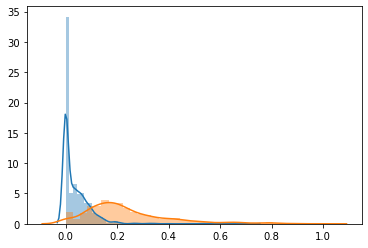

In [23]:
negative_scores = [score['neg'] for score in scores[0]]
positive_scores = [score['pos'] for score in scores[0]]
sns.distplot(negative_scores)
sns.distplot(positive_scores)
plt.show()

In [24]:
def predict_vader_sentiment_weighted(scores, neg_weight=1):
    '''Predicts all scores for each of the 4 products'''
    predictions = defaultdict(list)
    for ix in range(4):
        for review_score in scores[ix]:
            if review_score['neg']*neg_weight >= review_score['pos']:
                predictions[ix].append(-1)
            else:
                predictions[ix].append(1)
    return predictions

In [25]:
ypred = predict_vader_sentiment_weighted(scores, neg_weight=1.5)
get_all_reports(ypred, Train)

octave pedal
              precision    recall  f1-score   support

          -1       0.45      0.56      0.50       222
           1       0.93      0.90      0.92      1530

    accuracy                           0.86      1752
   macro avg       0.69      0.73      0.71      1752
weighted avg       0.87      0.86      0.87      1752



fuzz pedal
              precision    recall  f1-score   support

          -1       0.24      0.48      0.32       152
           1       0.95      0.87      0.91      1828

    accuracy                           0.84      1980
   macro avg       0.60      0.68      0.62      1980
weighted avg       0.90      0.84      0.87      1980



delay pedal
              precision    recall  f1-score   support

          -1       0.23      0.61      0.34       321
           1       0.96      0.83      0.89      3676

    accuracy                           0.81      3997
   macro avg       0.60      0.72      0.61      3997
weighted avg       0.90      0.81 

It seems like vader sentiment just isn't going to cut it.

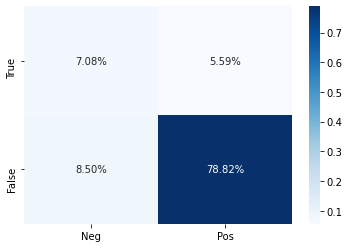

In [26]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(Train['y'][0], ypred[0])
y_ticks = ['True', 'False']
x_ticks = ['Neg', 'Pos']
labels = [y_ticks, x_ticks]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues', xticklabels=x_ticks, yticklabels=y_ticks);

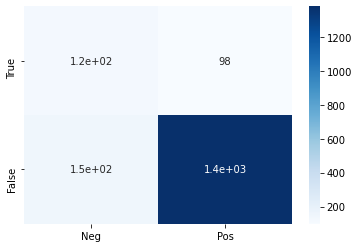

In [27]:
y_ticks = ['True', 'False']
x_ticks = ['Neg', 'Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=True, cmap='Blues', xticklabels=x_ticks, yticklabels=y_ticks);

## 2.2 Sentiment with Dimensionality Reduction
### 2.2.1 Model Selection

In [29]:
#first I'll work with the delay pedal train set
X = Train['X'][3]
test = Test['X'][3]
y_test = Test['y'][3]
y_train = Train['y'][3]

In [30]:
X_train, tfidf_vect = text_funcs.tfidf_vectorize(X, max_doc_freq=.8)
X_test = tfidf_vect.transform(test)
X_test = pd.DataFrame(X_test.toarray(), columns = tfidf_vect.get_feature_names())
X_test.index = test.index
X_train.index = X.index #keep original index

In [185]:
#PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= .95) + 1

In [186]:
d

1156

In [187]:
X_train.shape

(2695, 7413)

In [188]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=2)
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.15      1.00      0.27        76
           1       1.00      0.49      0.66       823

    accuracy                           0.54       899
   macro avg       0.58      0.75      0.46       899
weighted avg       0.93      0.54      0.63       899



In [189]:
from sklearn.naive_bayes import GaussianNB
cnb = GaussianNB()
cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.40      0.76      0.53        76
           1       0.98      0.90      0.93       823

    accuracy                           0.88       899
   macro avg       0.69      0.83      0.73       899
weighted avg       0.93      0.88      0.90       899



In [190]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.67      0.80        76
           1       0.97      1.00      0.99       823

    accuracy                           0.97       899
   macro avg       0.99      0.84      0.89       899
weighted avg       0.97      0.97      0.97       899



In [191]:
from sklearn.ensemble import GradientBoostingClassifier
forest = GradientBoostingClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.36      0.50        76
           1       0.94      1.00      0.97       823

    accuracy                           0.94       899
   macro avg       0.91      0.68      0.74       899
weighted avg       0.94      0.94      0.93       899



It seems like RandomForest does best, Let's grid search to find the best kernel for PCA.

In [209]:
from sklearn.decomposition import KernelPCA

#getting ideal n_components by getting the explained variance ratio:
kpca = KernelPCA(kernel='rbf')
kpca.fit(X_train)

#Kernel PCA doesn't have .explained_variance_ratio_, so I made my own
kpca_transform = kpca.fit_transform(X_train)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumsum = np.cumsum(explained_variance_ratio)

d = np.argmax(cumsum >= .95) + 1

In [210]:
d

1156

In [211]:
#getting ideal n_components by getting the explained variance ratio:
kpca = KernelPCA(kernel='sigmoid')
kpca.fit(X_train)

#Kernel PCA doesn't have .explained_variance_ratio_, so I made my own
kpca_transform = kpca.fit_transform(X_train)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumsum = np.cumsum(explained_variance_ratio)

d = np.argmax(cumsum >= .95) + 1

In [212]:
d

1156

It seems like the explained variance ratio is relatively independent of the kernel, so I'll set n_components to 1150

In [217]:
#Implementing f1_scorer
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score)

In [218]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

clf = Pipeline([
    ('kpca', KernelPCA()),
    ('forest', RandomForestClassifier())
])

param_grid = [{
    "kpca__n_components": [1150],
    "kpca__gamma": np.linspace(0.03, 0.05, 3),
    "kpca__kernel": ['linear', 'rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA()),
                                       ('forest', RandomForestClassifier())]),
             param_grid=[{'kpca__gamma': array([0.03, 0.04, 0.05]),
                          'kpca__kernel': ['linear', 'rbf', 'sigmoid'],
                          'kpca__n_components': [1150]}],
             scoring=make_scorer(f1_score))

In [219]:
grid_search.best_params_

{'kpca__gamma': 0.03, 'kpca__kernel': 'linear', 'kpca__n_components': 1150}

Let's do one final search to optimize gamma.

In [220]:
clf = Pipeline([
    ('kpca', KernelPCA()),
    ('forest', RandomForestClassifier())
])

param_grid = [{
    "kpca__n_components": [1150],
    "kpca__gamma": np.linspace(0.01, 0.039, 30),
}]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA()),
                                       ('forest', RandomForestClassifier())]),
             param_grid=[{'kpca__gamma': array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039]),
                          'kpca__n_components': [1150]}],
             scoring=make_scorer(f1_score))

In [223]:
grid_search.best_params_

{'kpca__gamma': 0.01, 'kpca__n_components': 1150}

In [224]:
#compare performance of grid searched model vs regular pca + forest
estimator = grid_search.best_estimator_
estimator.fit(X_train, y_train)

initial_estimator = Pipeline([
    ('pca', PCA(n_components=1150)),
    ('forest', RandomForestClassifier())
])

initial_estimator.fit(X_train, y_train)

ypred_e = estimator.predict(X_test)
ypred_ie = initial_estimator.predict(X_test)

print('Grid Search Estimator Results')
print(classification_report(y_test, ypred_e))
print('\n')
print('Initial Estimator Results')
print(classification_report(y_test, ypred_ie))

Grid Search Estimator Results
              precision    recall  f1-score   support

          -1       1.00      0.66      0.79        76
           1       0.97      1.00      0.98       823

    accuracy                           0.97       899
   macro avg       0.98      0.83      0.89       899
weighted avg       0.97      0.97      0.97       899



Initial Estimator Results
              precision    recall  f1-score   support

          -1       1.00      0.66      0.79        76
           1       0.97      1.00      0.98       823

    accuracy                           0.97       899
   macro avg       0.98      0.83      0.89       899
weighted avg       0.97      0.97      0.97       899



I'll stick with the initial pipeline since the kernal pca didn't improve my results too much.

In [225]:
sentiment_analyzer = initial_estimator

### 2.2.2 Extracting Sentiment With selected model

In [31]:
import pickle

In [32]:
%cd /home/dyllanjr/Documents/NLP_M4/models

/home/dyllanjr/Documents/NLP_M4/models


In [33]:
f1_scores = []
for ix in range(4):
    X = Train['X'][ix]
    test = Test['X'][ix]
    y_test = Test['y'][ix]
    y_train = Train['y'][ix]
    X_train, tfidf_vect = text_funcs.tfidf_vectorize(X, max_doc_freq=.8)
    X_test = tfidf_vect.transform(test)
    X_test = pd.DataFrame(X_test.toarray(), columns = tfidf_vect.get_feature_names())
    X_test.index = test.index #keep original index
    X_train.index = X.index #keep original index
    sentiment_analyzer.fit(X_train, y_train)
    ypred = sentiment_analyzer.predict(X_test)
    f1_scores.append(f1_score(y_test, ypred))
    
    
    filename = f'{Train["pedal"][ix]}.pkl'
    pickle.dump(sentiment_analyzer, open(filename, 'wb'))


NameError: name 'sentiment_analyzer' is not defined

In [333]:
print(classification_report(ypred, y_test))

              precision    recall  f1-score   support

          -1       0.66      1.00      0.79        50
           1       1.00      0.97      0.98       849

    accuracy                           0.97       899
   macro avg       0.83      0.98      0.89       899
weighted avg       0.98      0.97      0.97       899



In [243]:
print(f1_scores, np.mean(f1_scores))

[0.9541984732824427, 0.966183574879227, 0.9716535433070865, 0.9844497607655502] 0.9691213380585767


Works very well! I was going to try to do sentiment with word embeddings but I don't think it'd be very useful.

## 2.3 Extracting Highest and Lowest rated product for each pedal

In [34]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


In [35]:
pedals = ['delay_pedal', 'fuzz_pedal', 'octave_pedal', 'wah_pedal']

In [36]:
#Assigns sentiment for each pedal for each listing for each review
for pedal in pedals:
    reviews = corpus[pedal]['review']
    X, tfidf_vect = text_funcs.tfidf_vectorize(reviews, max_doc_freq=.8)

    X_reduced = PCA(n_components=1150).fit_transform(X)
    forest = RandomForestClassifier()
    forest.fit(X_reduced, corpus[pedal]['2_group_rating'])
    sentiment = forest.predict(X_reduced)
    corpus[pedal]['sent_pred'] = sentiment

In [256]:
best_and_worst_products = {}
#Grabs the most positive and most negative sentiment listings:
for pedal in pedals:
    group = corpus[pedal].groupby(['listing'])['sent_pred'].agg([('sum', lambda x: x.mean()), 'count'])
    #Getting listings with more than 120 reviews
    group = group[group['count'] > 120]
    group = group['sum']
    most_positive = group.idxmax()
    most_negative = group.idxmin()
    best_and_worst_products[pedal] = (most_positive, most_negative)


In [257]:
best_and_worst_products

{'delay_pedal': ('Boss RV-6 Digital Delay/Reverb Guitar Effects Pedal - Delay & Reverb Effects Pedals - Effects - RV-6',
  'Behringer Vintage Delay VD400 Analog Delay Effects Pedal - Delay & Reverb Effects Pedals - Effects - VD400'),
 'fuzz_pedal': ('Electro-Harmonix Bass Big Muff Pi Bass Fuzz Pedal',
  'Boss DS-1 Distortion Pedal, Orange'),
 'octave_pedal': ('DigiTech Drop Polyphonic Drop Tune Pitch-Shift Pedal Processor',
  'Boss DS-1 Distortion Pedal, Orange'),
 'wah_pedal': ('Dunlop Dimebag Cry Baby from Hell Wah Pedal',
  'Dunlop 535Q-B Cry Baby 535Q Multi-wah Pedal - Black')}

## 3 - Topic Modelling
---
### 3.1 - TFIDF + NMF

In [263]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

### Delay Pedal Topics

In [264]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

#best and worst product from delay reviews
delay_df = corpus['delay_pedal']
best_listing = best_and_worst_products['delay_pedal'][0]
worst_listing = best_and_worst_products['delay_pedal'][1]
best_df = delay_df[delay_df['listing'] == best_listing]
worst_df = delay_df[delay_df['listing'] == worst_listing]
best_reviews = best_df.review
worst_reviews = worst_df.review

In [265]:
best_pros = (best_df.sent_pred == 1)
best_cons = (best_df.sent_pred == -1)
worst_pros = (worst_df.sent_pred == 1)
worst_cons = (worst_df.sent_pred == -1)

In [266]:
print('worst sentiment score:', worst_df.sent_pred.mean())
print('best sentiment score:', best_df.sent_pred.mean())

worst sentiment score: 0.6527777777777778
best sentiment score: 0.9506172839506173


In [267]:
#I'll try a vanilla tfidf first
tfidf = TfidfVectorizer(stop_words='english', max_df=.7)
best_tfidf = tfidf.fit_transform(best_reviews)
best_tokens = tfidf.get_feature_names()
worst_tfidf = tfidf.fit_transform(worst_reviews)
worst_tokens = tfidf.get_feature_names()

In [268]:
#fitting nmf to best review listing
best_nmf_pros = NMF(n_components=4).fit(best_tfidf[best_pros])
best_nmf_cons = NMF(n_components=4).fit(best_tfidf[best_cons])

worst_nmf_pros = NMF(n_components=4).fit(worst_tfidf[worst_pros])
worst_nmf_cons = NMF(n_components=4).fit(worst_tfidf[worst_cons])

In [269]:
print_top_words(best_nmf_pros, best_tokens, 5)
print_top_words(best_nmf_cons, best_tokens, 5)

Topic #0: reverb sound use good shimmer
Topic #1: compact boss review pedal reverb
Topic #2: great pedal price recommend worth
Topic #3: does exactly want excellent works

Topic #0: says unuseable great reverbs giving
Topic #1: service receive took poor sweetwater
Topic #2: den så egentlig var første
Topic #3: wasnt fun didnt kind pretty



In [270]:
print_top_words(worst_nmf_pros, worst_tokens, 5)
print_top_words(worst_nmf_cons, worst_tokens, 5)

Topic #0: works good pedal price fine
Topic #1: analog delay year behrenger comlaints
Topic #2: great price vintage fast sound
Topic #3: use pedal sounds easy sound

Topic #0: thennuttin pay days worked range
Topic #1: right work working bad want
Topic #2: option supposed battery good havent
Topic #3: pedal great works power took



This does okay, but I'd like to take a look at some other options

### 3.2 - TFIDF + LDA (Latent Dirichlet Allocation)

In [271]:
from sklearn.decomposition import LatentDirichletAllocation
best_lda_pros = LatentDirichletAllocation(n_components=4).fit(best_tfidf[best_pros])
best_lda_cons = LatentDirichletAllocation(n_components=4).fit(best_tfidf[best_cons])

worst_lda_pros = LatentDirichletAllocation(n_components=4).fit(worst_tfidf[worst_pros])
worst_lda_cons = LatentDirichletAllocation(n_components=4).fit(worst_tfidf[worst_cons])

In [272]:
print_top_words(best_lda_pros, best_tokens, 5)
print_top_words(best_lda_cons, best_tokens, 5)

Topic #0: reverb boss pedal review compact
Topic #1: boss pedal reverb compact review
Topic #2: pedal great reverb effects boss
Topic #3: improved city works expect perfectly

Topic #0: service poor receive took horrible
Topic #1: says unuseable great reverbs use
Topic #2: den derfor egentlig fungerede okde
Topic #3: wasnt fun didnt kind pretty



In [273]:
print_top_words(worst_lda_pros, best_tokens, 5)
print_top_words(worst_lda_cons, best_tokens, 5)

Topic #0: mě river nearly effects flanged
Topic #1: amplified delicate gain mě trail
Topic #2: mě just fussy delicate behold
Topic #3: gain paddleboard mě delicate took

Topic #0: il awful check surprisingly fussy
Topic #1: got hall ay distortions meglio
Topic #2: river deal didnt tonal thank
Topic #3: módů modulated spend další tone



That seems to work a little better! Now I'll look as LSA

### 3.3 - TFIDF + LSA (Truncated Singular Value Decomposition)

In [274]:
from sklearn.decomposition import TruncatedSVD
best_lsa_pros = TruncatedSVD(n_components=4).fit(best_tfidf[best_pros])
best_lsa_cons = TruncatedSVD(n_components=4).fit(best_tfidf[best_cons])

worst_lsa_pros = TruncatedSVD(n_components=4).fit(worst_tfidf[worst_pros])
worst_lsa_cons = TruncatedSVD(n_components=4).fit(worst_tfidf[worst_cons])

In [275]:
print_top_words(best_lsa_pros, best_tokens, 5)
print_top_words(best_lsa_cons, best_tokens, 5)

Topic #0: pedal reverb great boss review
Topic #1: compact review boss kit piece
Topic #2: great pedal price buy worth
Topic #3: does excellent exactly want works

Topic #0: says unuseable great reverbs wasnt
Topic #1: den min første okde egentlig
Topic #2: service horrible sweetwater took poor
Topic #3: wasnt fun didnt kind pretty



In [276]:
print_top_words(worst_lsa_pros, best_tokens, 5)
print_top_words(worst_lsa_cons, best_tokens, 5)

Topic #0: mě gain delicate paddleboard fussy
Topic #1: amplified just delicate bedre color
Topic #2: amplified delicate trail color bedre
Topic #3: enjoy sweetwater důležité gain sólové

Topic #0: módů spend další tone place
Topic #1: modulated batteriet mě produce gain
Topic #2: modulated sing fussy batteriet glitchyness
Topic #3: tones tonal produce thank didnt



## Word Embedding

In [283]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
best_freq = count_vect.fit_transform(best_reviews).toarray()
best_tokens = count_vect.get_feature_names()
worst_freq = count_vect.fit_transform(worst_reviews).toarray()
worst_tokens = count_vect.get_feature_names()

### FastText

In [ ]:
!pip install Cython --install-option="--no-cython-compile"
!pip install fasttext
# download pre-trained language word vectors from one of 157 languges  https://fasttext.cc/docs/en/crawl-vectors.html
# it will take some time, about 5 minutes
import fasttext
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')


/home/dyllanjr/anaconda3/envs/metis/lib/python3.8/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 2.1 MB 1.6 MB/s eta 0:00:01
Skipping wheel build for Cython, due to binaries being disabled for it.
    Running setup.py install for Cython ... done
     |████████████████████████████████| 68 kB 1.1 MB/s eta 0:00:011
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=3025876 sha256=a778dc1f5c9406030c43f8b3ecac28a91b1d01cb53b9796a20c7a55e8060bccb
  Stored in directory: /home/dyllanjr/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext


In [ ]:
print(model.most_similar(positive=['woman', 'king'], negative=['man']))


# Playing with Glove

In [39]:
# NLP tools
import nltk
from genism.models import FastText

# Data tools
import numpy as np
import pandas as pd

pedal_df = corpus['delay_pedal']
pos, neg = best_and_worst_products['delay_pedal']
pos_sents = pedal_df[pedal_df['listing'] == pos]['review']
neg_sents = pedal_df[pedal_df['listing'] == neg]['review']


ModuleNotFoundError: No module named 'genism'

In [11]:
# NLP tools
import nltk
import gensim

# Data tools
import numpy as np
import pandas as pd

In [ ]:
model_ted = FastText(sentences_ted, size=100, window=5, min_count=5, workers=4,sg=1)
